In [1]:
from pprint import pformat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv("aggregated_results/main_results_2023-02-16.csv")
# df

In [3]:
# Take the mean score for each task across all runs
reduced_df = (
    df
    .groupby(["task_name", "network", "label", "method"], as_index=False)
    .mean()
    .drop(columns=["runid"])
)
# reduced_df

In [4]:
label_order = df.groupby("label")["test_log2pr"].median().sort_values(ascending=False).index.tolist()
print(f"Gene set collections sorted by mean performance across all methods:\n{pformat(label_order)}")

Gene set collections sorted by mean performance across all methods:
['diseases',
 'diseases_textminingfiltered',
 'diseases_knowledgefiltered',
 'disgenet_curated',
 'disgenet',
 'hpo',
 'disgenet_befree',
 'disgenet_animal',
 'diseases_experimentsfiltered',
 'disgenet_gwas']


In [5]:
method_order = df.groupby("method")["test_log2pr"].median().sort_values(ascending=False).index.tolist()
print(f"Methods sorted by mean performance across all gene set collections:\n{pformat(method_order)}")

Methods sorted by mean performance across all gene set collections:
['adj-logreg',
 'labelprop',
 'adj-svm',
 'graphsage',
 'gcn',
 'gin',
 'gat',
 'n2v-logreg',
 'n2v-svm']


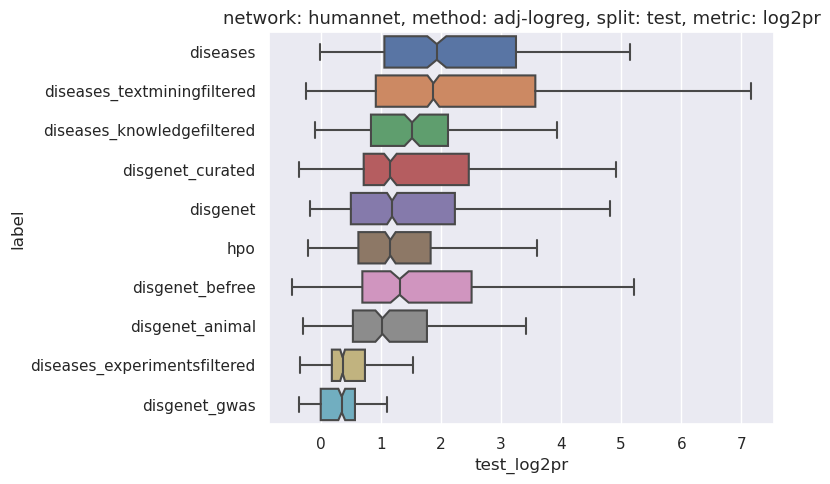

In [6]:
# -------------------
selected_network = "humannet"
selected_method = "adj-logreg"
selected_split = "test"
selected_metric = "log2pr"
# -------------------

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df.query("network == @selected_network & method == @selected_method"),
    x=f"{selected_split}_{selected_metric}",
    y="label",
    showfliers=False,
    notch=True,
    order=label_order,
)

plt.title(
    f"network: {selected_network}, "
    f"method: {selected_method}, "
    f"split: {selected_split}, "
    f"metric: {selected_metric}",
    fontsize=13,
)

plt.tight_layout()
plt.show()

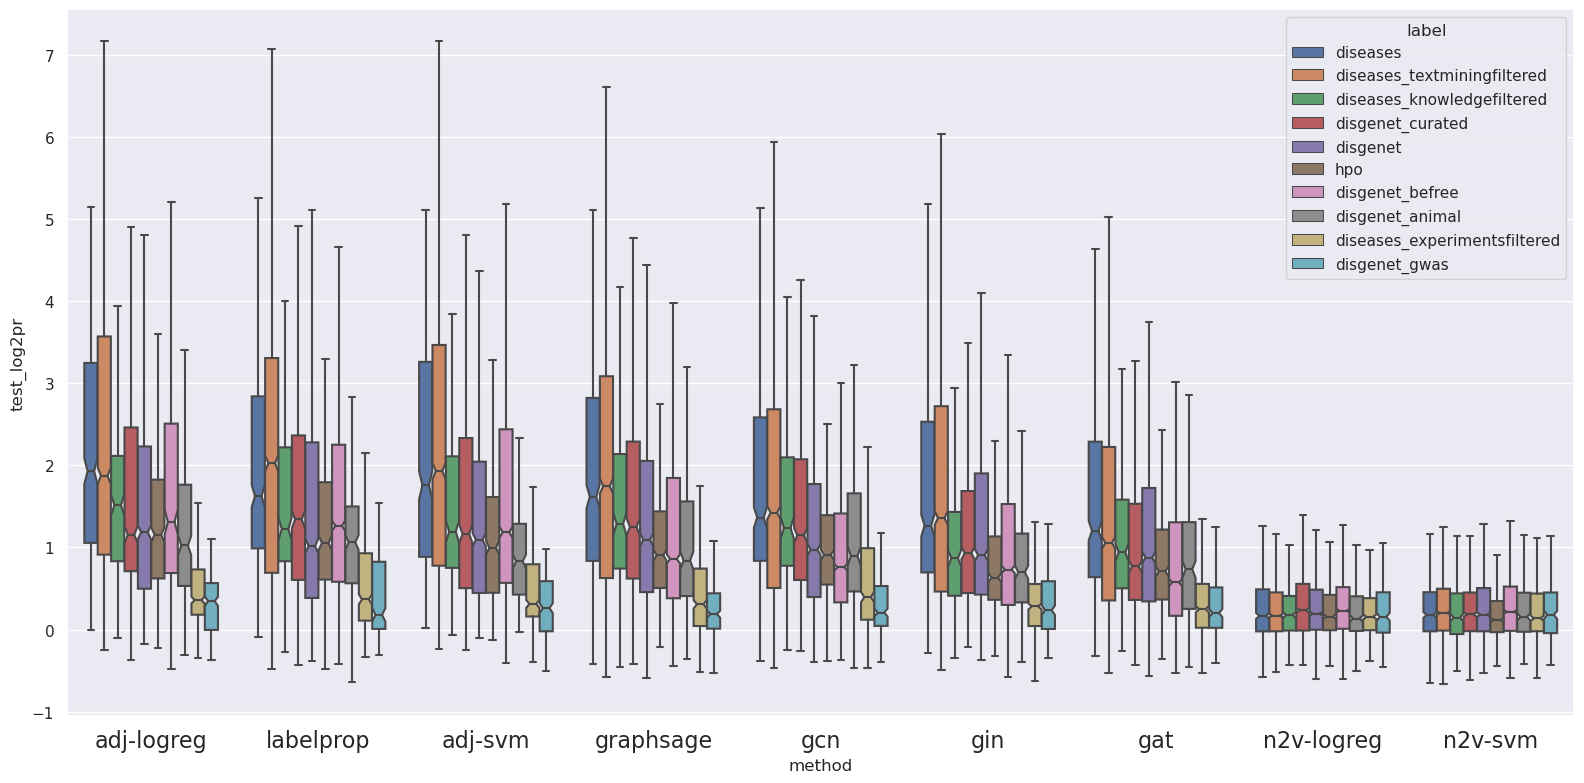

In [7]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=df.query("network == 'humannet'"),
    hue="label",
    y="test_log2pr",
    x="method",
    showfliers=False,
    notch=True,
    hue_order=label_order,
    order=method_order,
)

plt.xticks(fontsize=16)

plt.tight_layout()
plt.show()

- [ ] Note: `n2v` results are incorrect. Need to fix some bug. Possibly due to the `num_workers` issue (need to set to above 0, otherwise `w2v` is not run)

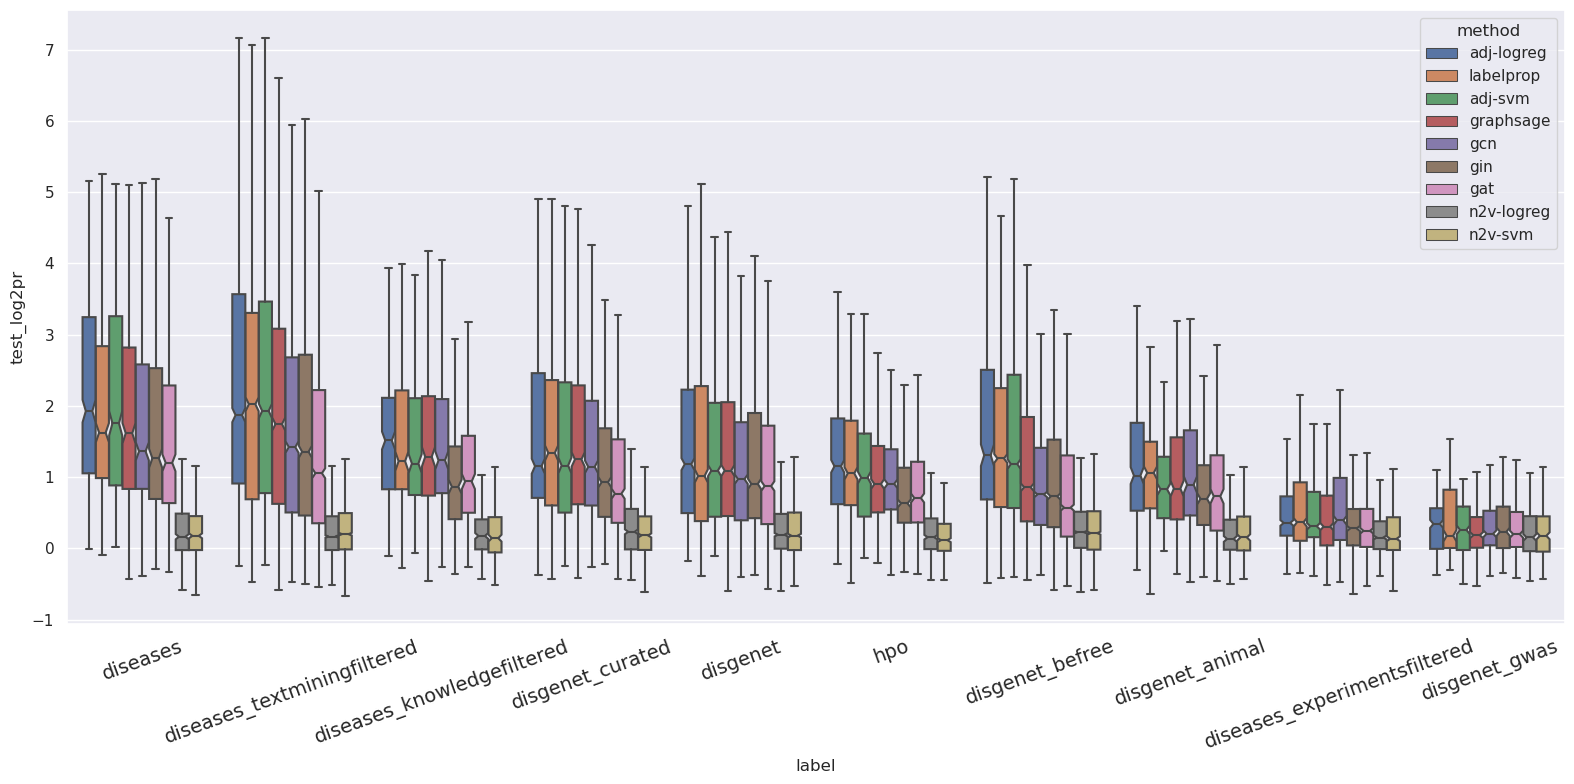

In [8]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=df.query("network == 'humannet'"),
    x="label",
    y="test_log2pr",
    hue="method",
    showfliers=False,
    notch=True,
    hue_order=method_order,
    order=label_order,
)
plt.xticks(fontsize=14, rotation=20)

plt.tight_layout()
plt.show()

In [9]:
# Take the average score across all tasks within a run
summary_df = df.groupby(["network", "label", "method", "runid"], as_index=False).mean(numeric_only=True)
summary_df

,network,label,method,runid,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,humannet,diseases,adj-logreg,0.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
1,humannet,diseases,adj-logreg,1.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
2,humannet,diseases,adj-logreg,2.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
3,humannet,diseases,adj-logreg,3.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
4,humannet,diseases,adj-logreg,4.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
...,...,...,...,...,...,...,...,...,...,...
441,humannet,hpo,n2v-svm,0.0,2.128756,0.204419,0.169398,0.780142,0.497200,0.490966
442,humannet,hpo,n2v-svm,1.0,2.132517,0.179518,0.343263,0.779935,0.485401,0.508777
443,humannet,hpo,n2v-svm,2.0,2.155960,0.149345,0.218030,0.778998,0.492844,0.493839
444,humannet,hpo,n2v-svm,3.0,2.127444,0.211468,0.106182,0.779434,0.502764,0.472958


In [10]:
def mean_std_str(x, *, k=4):
    mean = np.mean(x)
    std = np.std(x)
    return f"{mean:.{k}f} ± {std:.{k}f}"

selected_methods = ["adj-logreg", "adj-svm", "gat", "gcn", "gin", "graphsage", "labelprop"]

In [11]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str)[selected_methods]
    .style
    .highlight_max(color="lightgreen", axis=1)
    .highlight_max(color="lightblue", axis=0)
)

method,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,
diseases,2.1489 ± 0.0000,2.0528 ± 0.0000,1.5353 ± 0.0660,1.7668 ± 0.0641,1.6304 ± 0.0441,1.8649 ± 0.0257,2.0004 ± 0.0000
diseases_experimentsfiltered,0.6075 ± 0.0000,0.5500 ± 0.0000,0.4089 ± 0.0215,0.6486 ± 0.0612,0.4189 ± 0.0425,0.4782 ± 0.0453,0.5924 ± 0.0000
diseases_knowledgefiltered,1.7365 ± 0.0000,1.6271 ± 0.0000,1.2747 ± 0.0627,1.5967 ± 0.0633,1.1434 ± 0.1284,1.5510 ± 0.0420,1.5811 ± 0.0000
diseases_textminingfiltered,2.2615 ± 0.0000,2.2315 ± 0.0001,1.4444 ± 0.0693,1.7548 ± 0.0331,1.7592 ± 0.0462,1.9959 ± 0.0378,2.1562 ± 0.0000
disgenet,1.5617 ± 0.0000,1.4788 ± 0.0000,1.1837 ± 0.0427,1.2859 ± 0.0343,1.3262 ± 0.0500,1.4200 ± 0.0232,1.4406 ± 0.0000
disgenet_animal,1.1413 ± 0.0000,1.0380 ± 0.0000,0.9108 ± 0.0528,1.0710 ± 0.0607,0.8432 ± 0.0214,1.0333 ± 0.0416,1.0999 ± 0.0000
disgenet_befree,1.6813 ± 0.0000,1.5586 ± 0.0000,0.8848 ± 0.0882,1.0247 ± 0.0526,1.0565 ± 0.0979,1.2380 ± 0.0689,1.5416 ± 0.0000
disgenet_curated,1.6824 ± 0.0000,1.6149 ± 0.0000,1.0911 ± 0.0489,1.5339 ± 0.0578,1.2349 ± 0.0648,1.5734 ± 0.0508,1.5822 ± 0.0000
disgenet_gwas,0.5562 ± 0.0000,0.4906 ± 0.0000,0.3633 ± 0.0240,0.4356 ± 0.0317,0.4614 ± 0.0714,0.4424 ± 0.0263,0.4866 ± 0.0000


In [12]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")[selected_methods]
    .style
    .background_gradient(cmap="viridis", axis=1)
)

method,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,
diseases,2.148892,2.052846,1.535317,1.766804,1.630367,1.864945,2.000371
diseases_experimentsfiltered,0.607535,0.550002,0.408897,0.648558,0.418930,0.478154,0.592420
diseases_knowledgefiltered,1.736521,1.627125,1.274713,1.596721,1.143359,1.550980,1.581053
diseases_textminingfiltered,2.261506,2.231498,1.444382,1.754844,1.759175,1.995852,2.156249
disgenet,1.561691,1.478798,1.183720,1.285928,1.326207,1.419996,1.440647
disgenet_animal,1.141314,1.037989,0.910776,1.071028,0.843157,1.033257,1.099949
disgenet_befree,1.681334,1.558626,0.884782,1.024702,1.056520,1.238039,1.541587
disgenet_curated,1.682385,1.614927,1.091096,1.533926,1.234930,1.573371,1.582242
disgenet_gwas,0.556153,0.490572,0.363260,0.435591,0.461447,0.442420,0.486612


Notes
- In contrast to the main results shown in the ``nlevel`` v1 manuscript, ``GAT`` performs poorly, which might because it is hard to tune and thus rquires some efforts to tune it to the optimal performance.

In [13]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")[selected_methods]
    .style
    .background_gradient(cmap="viridis", axis=0)
)

method,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,
diseases,2.148892,2.052846,1.535317,1.766804,1.630367,1.864945,2.000371
diseases_experimentsfiltered,0.607535,0.550002,0.408897,0.648558,0.418930,0.478154,0.592420
diseases_knowledgefiltered,1.736521,1.627125,1.274713,1.596721,1.143359,1.550980,1.581053
diseases_textminingfiltered,2.261506,2.231498,1.444382,1.754844,1.759175,1.995852,2.156249
disgenet,1.561691,1.478798,1.183720,1.285928,1.326207,1.419996,1.440647
disgenet_animal,1.141314,1.037989,0.910776,1.071028,0.843157,1.033257,1.099949
disgenet_befree,1.681334,1.558626,0.884782,1.024702,1.056520,1.238039,1.541587
disgenet_curated,1.682385,1.614927,1.091096,1.533926,1.234930,1.573371,1.582242
disgenet_gwas,0.556153,0.490572,0.363260,0.435591,0.461447,0.442420,0.486612


**Summary**: Difficulties for the network based machine learning methods to capture different annotation sources can be roughly ordered as follow:
    *experiments* > *inferred* > *curated* > *text-mined*

Notes
- The ranking of 'difficulties' of the different gene set collections are consistent across all methods
- Both `DisGeNET` and `DISEASES` show similar trends, where
    - Text-mined annotations (`diseases_textminingfiltered` and `disgenet_befree`) can be best captured by all methods
    - Curated annotations (`diseases_knowledgefiltered` and `disgenet_curated`) are less well captured than text-mined annotations.
    - Inffered annotations (`disgenet_animal`, `hpo`) are even harder to be captured.
    - Annotations by high-throughput experiments (`diseases_experimentsfiltered`, `disgenet_gwas`) are the hardest to capture by any network based machine learing methods.

In [14]:
# # Export to latex
# print(
#     summary_df
#     .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str)[selected_methods]
#     .style
#     .to_latex()
# )